In [1]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from pathlib import Path
import pyvista as pv
import seaborn as sns
import pandas as pd
import numpy as np
import os
import glob
from tqdm import tqdm

In [2]:
DATASET_NAME = 'RF_FULGUR_M_MESH'
DATA_PATH = Path('./OUTPUT') / DATASET_NAME
PCA_RESULTS = DATA_PATH / 'PCA_results'
PARTICLES = DATA_PATH / f'{DATASET_NAME}_default_particles'


In [3]:
def load_shapes(directory, particle_type="world"):
    shapes = []
    for filename in os.listdir(directory):
        if filename.endswith(particle_type+'.particles'):
            filepath = os.path.join(directory, filename)
            shape = np.loadtxt(filepath)
            shapes.append(shape)
    return shapes

def load_eigenvectors(directory):
    eigenvectors = []
    files = sorted(os.listdir(directory))
    for filename in files:
        if filename.endswith('.eig'):
            filepath = os.path.join(directory, filename)
            eigenvector = np.loadtxt(filepath)
            eigenvectors.append(eigenvector)
    return np.array(eigenvectors)

In [4]:
real_shapes = load_shapes(PARTICLES, "world")
eigenvalues = np.loadtxt(PCA_RESULTS / 'eigenvalues.eval')
eigenvectors = load_eigenvectors(PCA_RESULTS)
eigenvectors = np.array([vec / np.linalg.norm(vec) for vec in eigenvectors])

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'OUTPUT\\RF_FULGUR_M_MESH\\RF_FULGUR_M_MESH_default_particles'

In [ ]:
np_real_shapes = np.asarray(real_shapes)        # (N, d)
np_eigenvectors = np.asarray(eigenvectors)
np_eigenvalues  = np.asarray(eigenvalues)

print(f"{np_real_shapes.shape=}")
print(f"{np_eigenvectors.shape=}")
print(f"{np_eigenvalues.shape=}")

np_real_shapes.shape=(28, 128, 3)
np_eigenvectors.shape=(27, 128, 3)
np_eigenvalues.shape=(27,)


---
## 1. Compactness

Nombre de composantes nécessaires pour dépasser 95% de variance cumulative : 4
Variance cumulative des 4 premières composantes : [0.8035034  0.91177262 0.94788778 0.95983867]


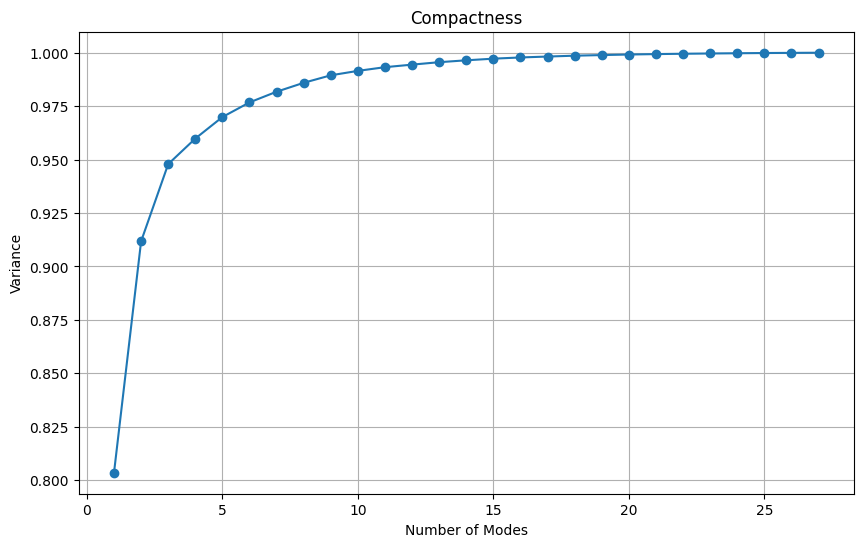

In [ ]:
def compute_compactness(eigenvalues, threshold=0.95):
    total_variance = np.sum(eigenvalues)
    cumulative_variance = np.cumsum(eigenvalues) / total_variance
    num_components = np.argmax(cumulative_variance >= threshold) + 1
    return num_components, cumulative_variance

num_components, cumulative_variance = compute_compactness(eigenvalues)

print(f"Nombre de composantes nécessaires pour dépasser {int(100 * 0.95)}% de variance cumulative : {num_components}")
print(f"Variance cumulative des {num_components} premières composantes : {cumulative_variance[:num_components]}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Number of Modes')
plt.ylabel('Variance')
plt.title('Compactness')
plt.grid(True)
plt.show()

---
## 2. Specificity Error

### Specificity (1 sample)

100%|██████████| 27/27 [00:25<00:00,  1.04it/s]


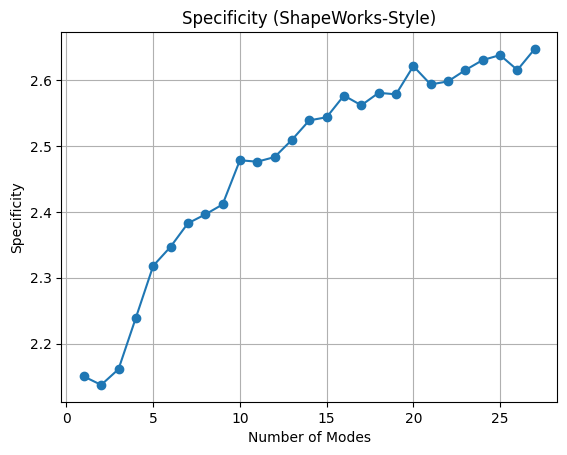

In [ ]:
def compute_specificity(
    real_shapes,
    num_particles,
    num_samples=1000,
):
    """
    Cette fonction reproduit le calcul de la spécificité selon la logique de ShapeWorks.
    Elle accepte un tableau de formes 3D (n, 3*p) ou (n, p, 3). 
    """

    # Convertion (n, p, 3) => (n, 3*p) = (n, d)
    n, p, dim3 = real_shapes.shape
    d = p * dim3
    real_shapes = real_shapes.reshape(n, d)

    Y = real_shapes.T       # (d, n) 
    mu = np.mean(          
        Y,                  # Shapes transposées
        axis=1,             # Moyenne par colonne
        keepdims=True       # Pour garder la forme (d, 1)
    )
    
    Y_centered = Y - mu     # Centrage des données

    U, S, Vt = np.linalg.svd(   # SVD
        Y_centered,             # (d, n)
        full_matrices=False     # économise la mémoire
    )
    
    if S[0] < S[-1]:            # Si ordre décroissant
        S = S[::-1]             # Inversion
        U = np.fliplr(U)        # Inversion
        Vt = np.flipud(Vt)      # Inversion

    specificities = np.zeros(n - 1) # Tableau de spécificités initialisé à 0
    training_data = Y.T             # (n, d)

    def shape_distance(ptsA, ptsB, pcount):             # Calcul de la distance entre deux formes
        A3 = ptsA.reshape(pcount, 3)                    # (p, 3)
        B3 = ptsB.reshape(pcount, 3)                    # (p, 3)
        return np.linalg.norm(A3 - B3, axis=1).sum()    # Somme des distances

    for m in tqdm(range(1, n)):   
        epsi = U[:, :m]               # epsi represente les m premiers vecteurs propres
        stdevs = np.sqrt(S[:m])       # stdevs represente les m premiers valeurs propres

        betas = np.random.randn(m, num_samples) # betas est un tableau (m, num_samples) de valeurs aléatoires (Gaussian Univariate Distribution)
        for i_mode in range(m): 
            betas[i_mode, :] *= stdevs[i_mode]  # Multiplication par les valeurs propres

        synthetic = epsi @ betas + mu           # Reconstruction des formes synthétiques

        min_dists = np.zeros(num_samples)       # Tableau de distances initialisé à 0
        for isyn in range(num_samples):         
            synth_i = synthetic[:, isyn]        # Forme synthétique i
            best = 1e15                         # Initialisation de la meilleure distance
            for j in range(n):                      
                dist_ij = shape_distance(synth_i, training_data[j], num_particles)      # Calcul de la distance entre la forme synthétique et la forme réelle
                if dist_ij < best:                                                      # Si la distance est meilleure
                    best = dist_ij                                                      
            min_dists[isyn] = best

        avg_min = np.mean(min_dists)                                                    # Moyenne des meilleures distances
        specificities[m-1] = avg_min / float(num_particles)

    return specificities

p = len(real_shapes[1]) # p = 128

specifics = compute_specificity(
    np.asarray(real_shapes), 
    num_particles=p, 
    num_samples=1000
)

modes_x = np.arange(1, len(specifics)+1)

plt.figure()
plt.plot(modes_x, specifics, marker='o')
plt.xlabel("Number of Modes")
plt.ylabel("Specificity")
plt.title("Specificity (ShapeWorks-Style)")
plt.grid(True)
plt.show()


### Vérification (Erreur Formes Réeles = 0)

Modes:   0%|          | 0/27 [00:00<?, ?it/s]

Modes: 100%|██████████| 27/27 [00:00<00:00, 160.01it/s]


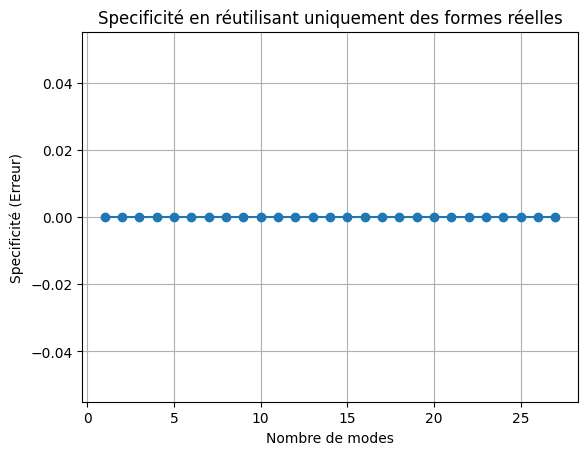

In [ ]:
def test_specificity_zero(real_shapes, num_particles):
    n, p, dim3 = real_shapes.shape
    d = p * dim3
    reshaped = real_shapes.reshape(n, d)
    if d != 3 * num_particles:
        raise ValueError(f"d={d}, attendu 3*num_particles={3*num_particles}")
    Y = reshaped.T
    mu = np.mean(Y, axis=1, keepdims=True)
    Y_centered = Y - mu
    U, S, Vt = np.linalg.svd(Y_centered, full_matrices=False)
    if S[0] < S[-1]:
        S = S[::-1]
        U = np.fliplr(U)
        Vt = np.flipud(Vt)
    specificities = np.zeros(n - 1)
    real_reshaped = reshaped.reshape(n, num_particles, 3)
    for m in tqdm(range(1, n), desc="Modes"):
        synthetic = Y
        synth_reshaped = synthetic.T.reshape(n, num_particles, 3)
        diff = synth_reshaped[:, None, :, :] - real_reshaped[None, :, :, :]
        dists_point = np.linalg.norm(diff, axis=3)
        dists_sum = dists_point.sum(axis=2)
        min_dists = dists_sum.min(axis=1)
        avg_min = np.mean(min_dists) / float(num_particles)
        specificities[m - 1] = avg_min
    return specificities

specifics_real = test_specificity_zero(np.asarray(real_shapes), num_particles=p)
modes_x = np.arange(1, len(specifics_real) + 1)
plt.figure()
plt.plot(modes_x, specifics_real, marker='o')
plt.xlabel("Nombre de modes")
plt.ylabel("Specificité (Erreur)")
plt.title("Specificité en réutilisant uniquement des formes réelles")
plt.grid(True)
plt.show()


### 3. Generalization Error

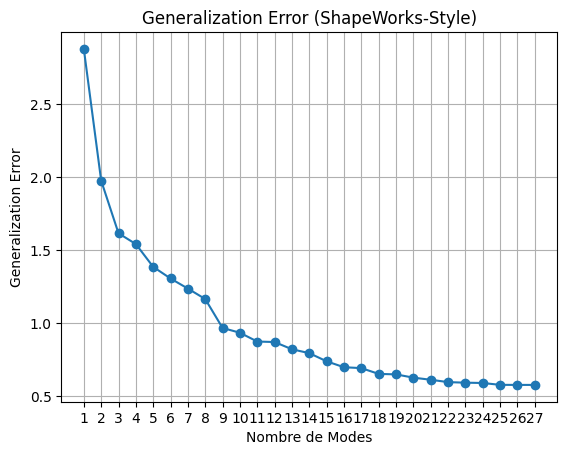

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compute_generalization_shapeworks_style(
    real_shapes,
    num_particles
):

    if len(real_shapes.shape) == 3 and real_shapes.shape[2] == 3:
        n, p, dim3 = real_shapes.shape
        d = p * dim3
        real_shapes = real_shapes.reshape(n, d)
    else:
        n, d = real_shapes.shape

    if d != 3 * num_particles:
        raise ValueError(f"Dimension d={d} ne correspond pas à 3*num_particles={3*num_particles}")

    # Transpose => (d, n)
    P = real_shapes.T

    # On préparera un vecteur de résultats
    generalizations = np.zeros(n - 1)

    # Fonction distance 3D en sommant sur les num_particles
    def shape_distance(ptsA, ptsB, pcount):
        A3 = ptsA.reshape(pcount, 3)
        B3 = ptsB.reshape(pcount, 3)
        return np.linalg.norm(A3 - B3, axis=1).sum()

    # Pour calculer l'erreur pour m modes, on reproduit la logique "full_generalization" :
    # On effectue un leave-one-out, on reconstruit chaque forme, on calcule la dist, 
    # on accumule, puis on moyenne.
    for m in range(1, n):
        total_dist = 0.0

        for leave in range(n):
            # Exclut la colonne "leave" pour construire Y
            Y = np.zeros((d, n-1))
            Y[:, :leave] = P[:, :leave]
            Y[:, leave:] = P[:, leave+1:]

            # Moyenne et centrage
            mu = np.mean(Y, axis=1, keepdims=True)
            Y_centered = Y - mu

            # SVD
            U, S, Vt = np.linalg.svd(Y_centered, full_matrices=False)

            # Les m premières colonnes de U
            epsi = U[:, :m]

            # La forme exclue
            y_test = P[:, leave:leave+1]

            # Projection & reconstruction
            betas = epsi.T @ (y_test - mu)
            rec = epsi @ betas + mu

            # Distance par point => somme => divisé par num_particles
            dist = shape_distance(rec, y_test, num_particles) / float(num_particles)
            total_dist += dist

        # Moyenne sur n
        generalizations[m - 1] = total_dist / float(n)

    return generalizations

n, p = 28, 128

gen_errors = compute_generalization_shapeworks_style(
    np.asarray(real_shapes),
    p
)

modes = np.arange(1, len(gen_errors) + 1)

import matplotlib.pyplot as plt

plt.figure()
plt.plot(modes, gen_errors, marker='o')
plt.xlabel("Nombre de Modes")
plt.xticks(modes)
plt.ylabel("Generalization Error")
plt.title("Generalization Error (ShapeWorks-Style)")
plt.grid(True)
plt.show()
